## K-Prototypes

Para a segmentação dos clientes neste projeto, foi utilizado o modelo K-Prototypes, considerando-se a natureza mista das variáveis presentes no conjunto de dados. A base inclui variáveis quantitativas, como idade e renda, além de variáveis qualitativas, como ocupação, nível de escolaridade e estado civil. Diferentemente de algoritmos como o K-Means, que lida apenas com variáveis numéricas, e o K-Modes, voltado exclusivamente para variáveis categóricas, o K-Prototypes é capaz de tratar ambos os tipos simultaneamente. Essa característica torna o modelo mais adequado para representar os diferentes perfis de clientes de forma mais precisa, permitindo uma segmentação mais coerente e alinhada à heterogeneidade dos dados.



In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../src') 
from utils import analise_bivariada_dist


In [ ]:
# Carregando o arquivo processado
df = pd.read_csv('../data/processed/segmentation_processed.csv')

# Copia do dataframe original para analise pós aplicação de modelo
df_customers = df.copy()

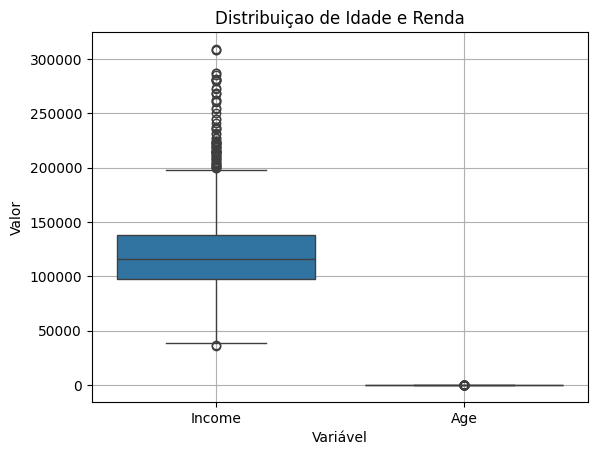

In [6]:
### Verificando distribuição das variáveis numéricas
analise_bivariada_dist(df, ['Income','Age'])

Devido a diferença entre as escaladas das variáveis que representam renda e idade, faz-se necessário a utilização do processo de padronização de ambas para que não existam influência desproporcional no cálculo das distâncias durante o processo de clusterização.

In [9]:
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']]) 

In [13]:
# Retorna uma matriz Numpy para aplicar o K-prototypes
x = df.values

In [ ]:
# Custo total - verificação para definir o melhor agrupamento (teste inicial - 10 clusters)
costs = []
K = range(1,10)

for k in K:
    kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0)
    clusters = kproto.fit_predict(x, categorical=[0,1,3,5,6])
    costs.append(kproto.cost_)


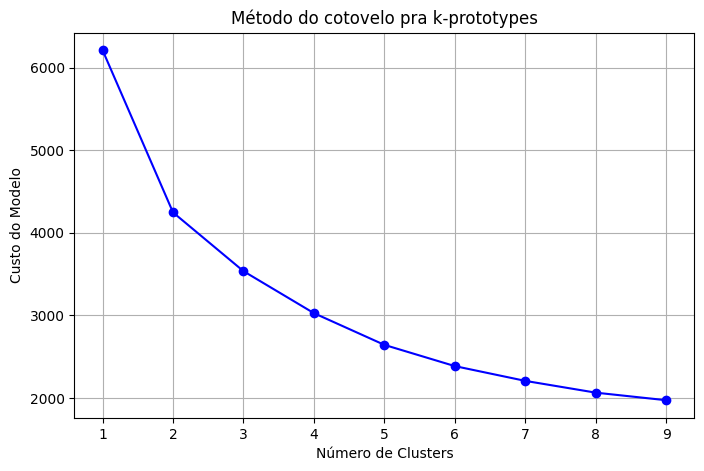

In [16]:
# Imprimindo o custo total para cada cluster gerado
plt.figure(figsize=(8,5))
plt.plot(K, costs, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Custo do Modelo')
plt.title('Método do cotovelo pra k-prototypes')
plt.grid(True)
plt.show()

O gráfico acima mostra como o custo de clusterização diminui à medida que aumentamos o número de clusters k. O "cotovelo" é o ponto onde essa redução começa a se estabilizar, indicando que aumentar k além dali traz pouco ganho de qualidade. Esse ponto é considerado o número ideal de clusters, pois representa um bom equilíbrio entre simplicidade e desempenho.

Deste modo pela interpretação do gráfico gerado tomou-se como base n=5 clusters visto que a partir deste ponto a redução do custo começa a se estabilizar e também é possível ver a dobra do "cotovelo".


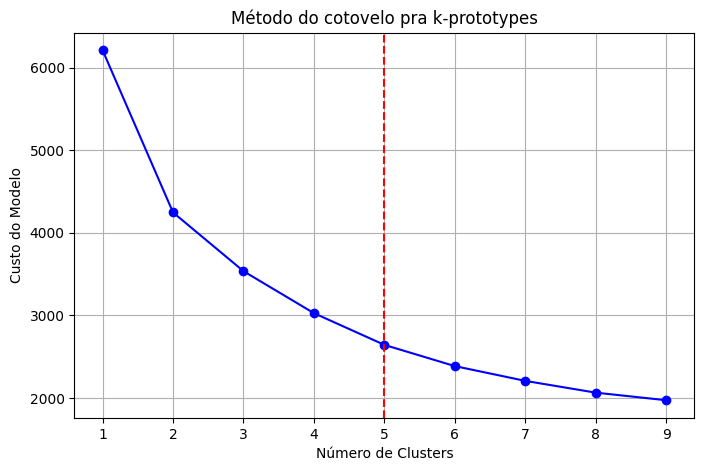

In [ ]:
# Gráfico de custo com corte em 5 clusters
plt.figure(figsize=(8,5))
plt.plot(K, costs, 'bo-')
plt.axvline(x=5, color='r', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('Custo do Modelo')
plt.title('Método do cotovelo pra k-prototypes')
plt.grid(True)
plt.show()

In [21]:
# Aplicando o k-prototypes para o modelo final com 5 clusters
kproto = KPrototypes(n_clusters=5, init='Huang', verbose=0)
clusters= kproto.fit_predict(x, categorical=[0,1,3,5,6])

In [26]:
# Adicionando os clusters ao dataframe original
df_customers['cluster'] = clusters

In [ ]:

df_customers.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,cluster
0,Male,single,67,university,124670,skilled employee/official,big city,4
1,female,non-sngle,22,high school,150773,skilled employee/official,big city,2
2,Male,single,49,high school,89210,unemployed/unskilled,small city,0
3,Male,single,45,high school,171565,skilled employee/official,mid-sized city,3
4,Male,single,53,high school,149031,skilled employee/official,mid-sized city,3


In [31]:
# Realizando análise dentro dos clusters
metrics = (df_customers.groupby('cluster').agg({
    'Sex': lambda x: x.mode()[0],
    'Marital status': lambda x: x.mode()[0],
    'Age': 'mean',
    'Education': lambda x: x.mode()[0],
    'Income': 'mean',
    'Occupation': lambda x:x.mode()[0],
    'Settlement size': lambda x: x.mode()[0]
}))

metrics = pd.DataFrame(metrics).reset_index()


In [35]:
# Criando coluna renda média por mês
metrics['Income_mean'] = metrics['Income']/12
# Ordenando as colunas
colunas_ord = ['cluster', 'Sex', 'Marital status', 'Age', 'Education', 'Income','Income_mean', 'Occupation', 'Settlement size']
metrics = metrics[colunas_ord]

In [36]:
metrics

,cluster,Sex,Marital status,Age,Education,Income,Income_mean,Occupation,Settlement size
0,0,Male,single,33.080000,high school,80707.708235,6725.642353,unemployed/unskilled,small city
1,1,Male,single,41.625000,high school,220192.910714,18349.409226,management/highly qualified employee,big city
2,2,female,non-sngle,26.978395,high school,111375.049383,9281.254115,skilled employee/official,small city
3,3,Male,single,37.148352,high school,136784.073260,11398.672772,skilled employee/official,mid-sized city
4,4,female,non-sngle,56.996283,university,134168.475836,11180.706320,skilled employee/official,small city


##  Análise por Cluster

Com base nas médias das variáveis de cada grupo, obtemos os seguintes perfis:

###  Cluster 0
- **Sexo predominante:** Masculino  
- **Estado civil:** Solteiros  
- **Idade média:** 33 anos  
- **Educação:** Ensino médio
- **Renda Anual:** ~\$80.707,70  
- **Renda média mensal:** ~\$6.725,64  
- **Ocupação:** Desempregado ou não qualificado  
- **Tamanho do município:** Cidade pequena  

> Jovens adultos solteiros, com baixa renda e qualificação, residentes em pequenas cidades.

---

###  Cluster 1
- **Sexo predominante:** Masculino  
- **Estado civil:** Solteiros  
- **Idade média:** 41,6 anos  
- **Educação:** Ensino médio  
- **Renda Anual:** ~\$220.192,91 
- **Renda média mensal:** ~\$18.349,41  
- **Ocupação:** Gestão / altamente qualificado  
- **Tamanho do município:** Grande cidade  

> Homens com idade média, alta renda e atuação em cargos de gestão ou técnicos, residentes em grandes centros urbanos.

---

###  Cluster 2
- **Sexo predominante:** Feminino  
- **Estado civil:** Não solteiras  
- **Idade média:** 27 anos  
- **Educação:** Ensino médio
- **Renda Anual:** ~\$111.375,04    
- **Renda média mensal:** ~\$9.281,25  
- **Ocupação:** Funcionária qualificada  
- **Tamanho do município:** Cidade pequena  

> Mulheres jovens, em relacionamentos, com renda mediana e atuação em ocupações técnicas, em cidades pequenas.

---

###  Cluster 3
- **Sexo predominante:** Masculino  
- **Estado civil:** Solteiros  
- **Idade média:** 37 anos  
- **Educação:** Ensino médio 
- **Renda Anual:** ~\$136.784,07
- **Renda média mensal:** ~\$11.398,67  
- **Ocupação:** Funcionário qualificado  
- **Tamanho do município:** Cidade média  

> Homens de meia-idade, solteiros, com renda razoável e empregos técnicos, em centros urbanos de médio porte.

---

###  Cluster 4
- **Sexo predominante:** Feminino  
- **Estado civil:** Não solteiras  
- **Idade média:** 57 anos  
- **Educação:** Ensino superior
- **Renda Anual:** ~\$134.168,47  
- **Renda média mensal:** ~\$11.180,70  
- **Ocupação:** Funcionária qualificada  
- **Tamanho do município:** Cidade pequena  

> Mulheres mais velhas, com nível superior, boa renda e estabilidade, residindo em pequenas cidades.